In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

import models_pheno
import models_decode
import models_breed
import mnist
import neuroevolution
import coevolve_ne
import ordinary_ne

torch.manual_seed(10);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_idx = 0

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
# tb_log_dir = os.path.join(cp.data_dir, 'tensorboard/', user)
tb_log_dir = f'/tmp/tensorboard/{user}'
# print(tb_log_dir)
    

In [5]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

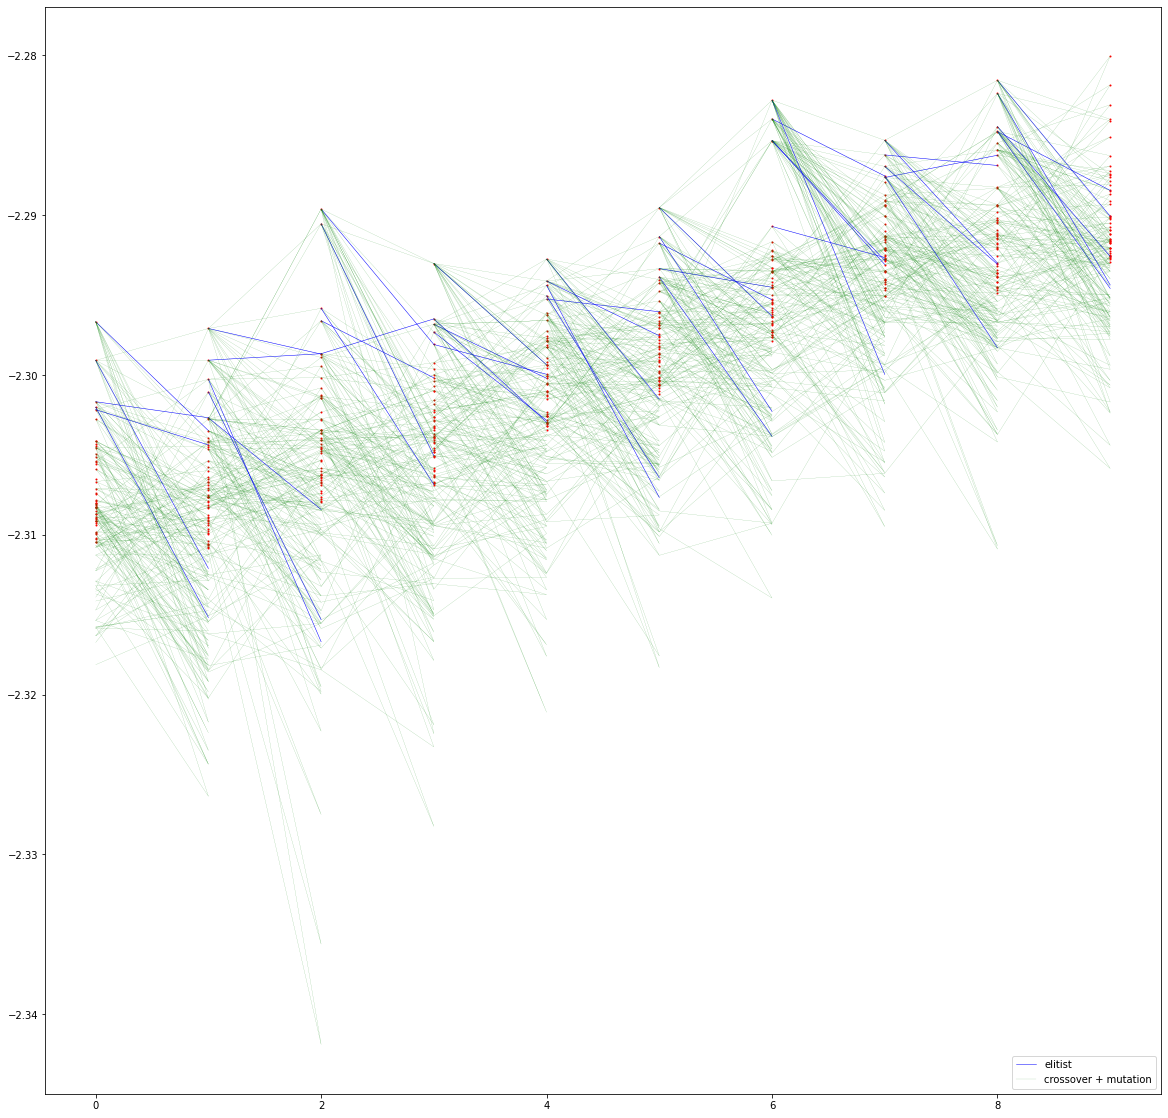

In [6]:
plt.figure(figsize=(20,20))
for gen_idx in range(10):
#     pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
    fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))
#     fitnesses = np.arange(100)[::-1]
    plt.scatter(np.full_like(fitnesses, gen_idx)[:50], fitnesses[:50], c='r', s=1)
    if gen_idx>0:
        fitnesses_prev = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx-1:05d}'))
#         fitnesses_prev = np.arange(100)[::-1]
        parents_idxs = torch.load(os.path.join(logger.log_dir, f'parent_idxs_gen_{gen_idx:05d}'))
        for i, p_idx in enumerate(parents_idxs):
            if p_idx.size==1:
                pass
                clone = plt.plot([gen_idx, gen_idx-1], [fitnesses[i], fitnesses_prev[p_idx]], c='b', linewidth=0.5)
            else:
                pass
                cross = plt.plot([gen_idx-1, gen_idx, gen_idx-1], 
                                 [fitnesses_prev[p_idx[0]], fitnesses[i], fitnesses_prev[p_idx[1]]], c='g', linewidth=0.1)
plt.legend([clone[0], cross[0]], ['elitist', 'crossover + mutation'], loc='lower right')
plt.show()
            


In [7]:
gen_idx = 999
# plt.figure(figsize=(20,20))
config = torch.load(os.path.join(logger.log_dir, 'config'))
pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))

In [8]:
breeder = models_breed.LinearBreeder(config)
decoder = models_decode.LinearDecoder(config)
pheno = models_pheno.SmallNet(config)
pheno = pop[0].to_pheno(decoder=decoder, pheno=pheno)

In [9]:
task.calc_pheo_fitness(pheno, device=device)

{'fitness': -1.0180243253707886, 'loss': 1.0180243253707886, 'accuracy': 0.662}

In [10]:
def to_pheno_mix_breed_decode(decoder_geno, dna1_geno, dna2_geno=None, breeder_geno=None,
                          decoder=decoder, pheno=pheno, breeder=breeder):
    if breeder_geno is None:
        dna = dna1_geno.dna
    else:
        breeder.load_breeder_dna(breeder_geno.breeder_dna)
        dna = breeder.breed_dna(dna1_geno.dna, dna2_geno.dna)
    decoder.load_decoder_dna(decoder_geno.decoder_dna)
    pheno_dna = decoder.decode_dna(dna)
    pheno.load_pheno_dna(pheno_dna)
    return pheno


In [11]:
def eval_evolution_with_good_geno(decode_kw, dna1_kw, dna2_kw, breeder_kw, n_samp=10, n_gen_skip=10):
    """
    This method lets you use already evolved DNA/decoder/breeder on evolving DNA/decoder/breeder
    to evaluate how their fitness changes throughout generations.
    decode_kw, dna1_kw, dna2_kw, breeder_kw can be one of
     - 'evol1': use randomly sampled evolving version
     - 'evol2': use randomly sampled evolving version #2
     - 'good1': use randomly sampled evolved version
     - 'good2': use randomly sampled evolved version #2
     - 'none': ignore
    """
    fit = np.zeros((1000, n_samp))
    pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{999:05d}'))
    gens = np.arange(1000)[::n_gen_skip]
    for gen_idx in tqdm(gens, leave=False):
        pop_ = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
        for i in range(n_samp):
            d = {'none': None}
            d['evol1'], d['evol2'] = np.random.choice(pop_, size=(2,), )
            d['good1'], d['good2'] = np.random.choice(pop, size=(2,), )
            pheno = to_pheno_mix_breed_decode(d[decode_kw], d[dna1_kw], d[dna2_kw], d[breeder_kw])
            fit[gen_idx, i] = task.calc_pheo_fitness(pheno, device=device)['fitness']
    return fit, gens

def viz_evolution_with_good_geno(fit, gens):
    plt.figure(figsize=(20, 10))
    x = np.tile(gens[:, None], (1, 10));y = fit[::10]
    plt.subplot(211)
    plt.scatter(x.flatten(), y.flatten(), s=2, c='r')
    plt.errorbar(x=x.mean(axis=-1), y=y.mean(axis=-1), yerr=y.std(axis=-1), elinewidth=1)
    plt.subplot(212)
    plt.scatter(x.flatten(), y.flatten(), s=2, c='r')
    plt.errorbar(x=x.mean(axis=-1), y=y.mean(axis=-1), yerr=y.std(axis=-1), elinewidth=1)
    plt.ylim(-2.3, -.8)


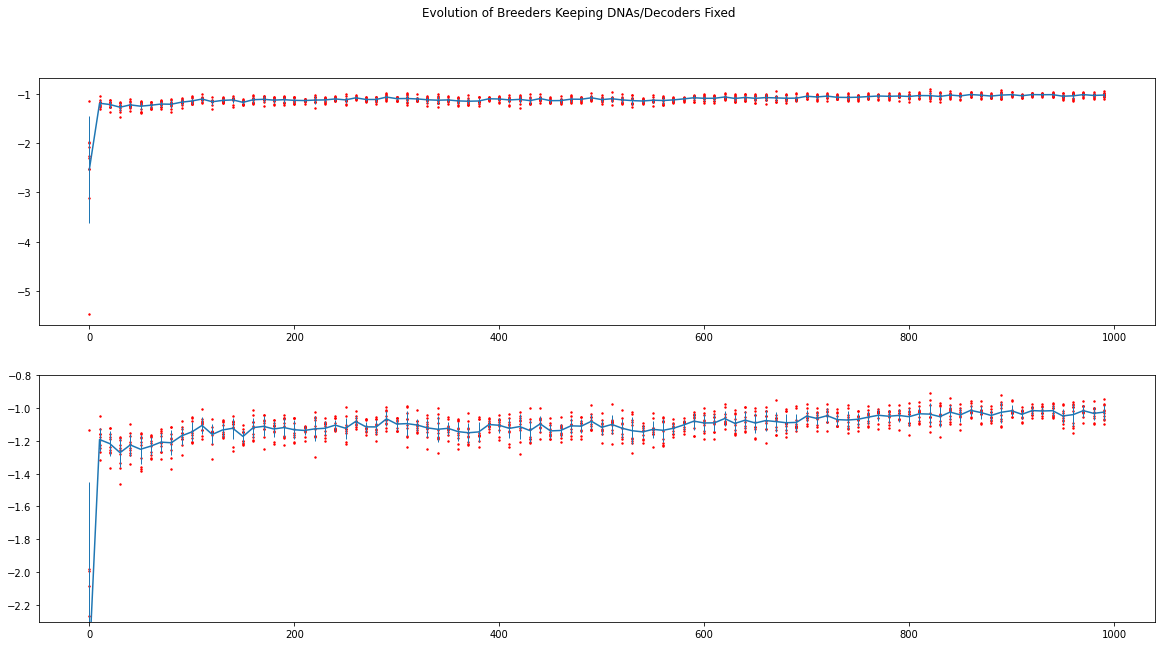

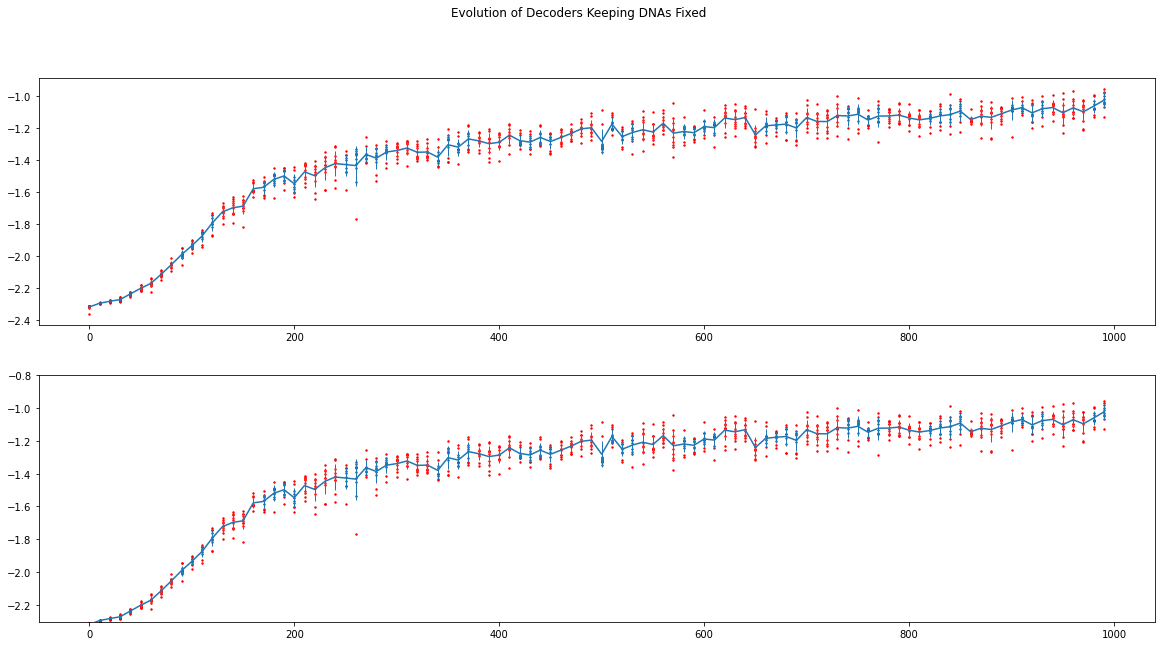

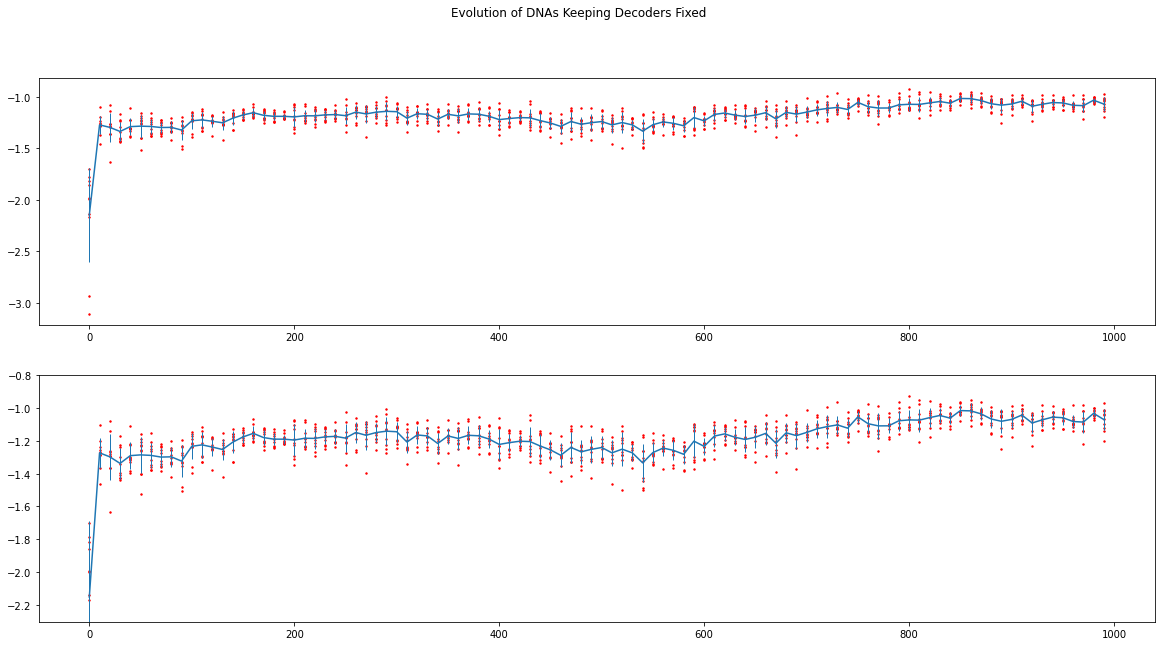

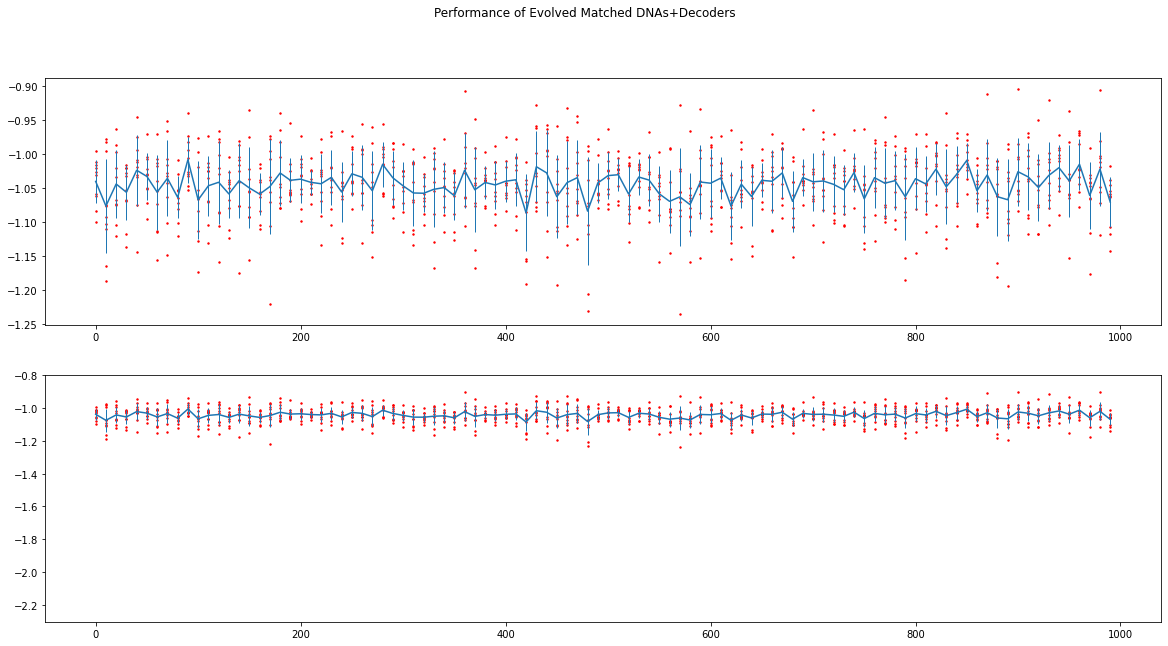

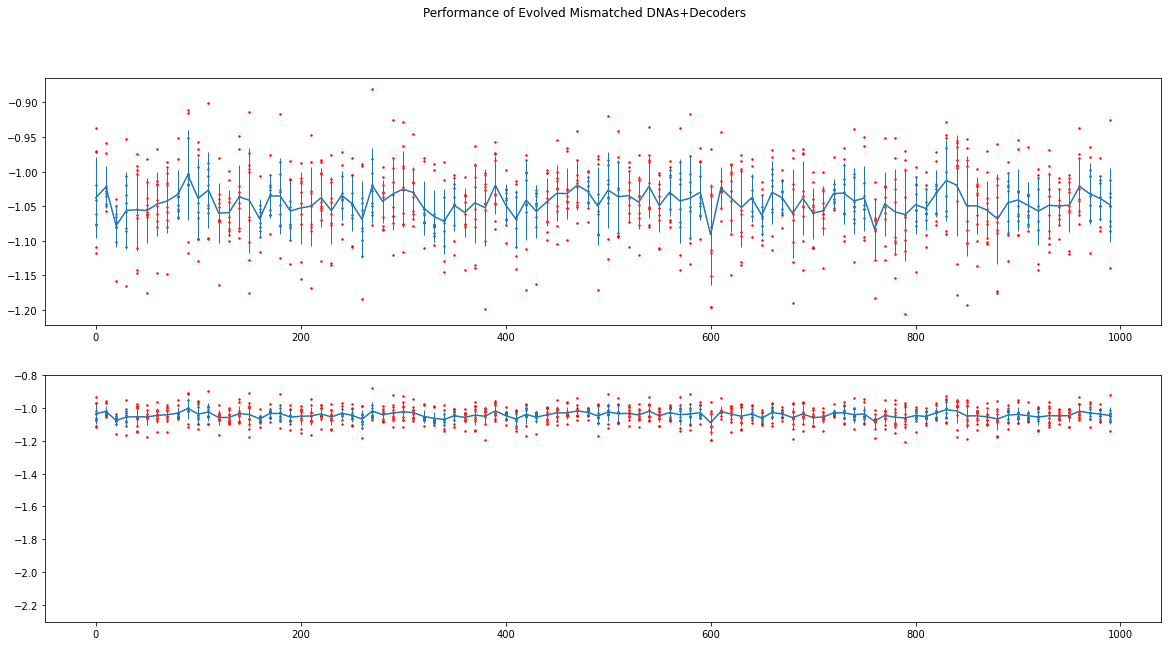

In [12]:
fit, gens = eval_evolution_with_good_geno('good1', 'good1', 'good2', 'evol1')
viz_evolution_with_good_geno(fit, gens)
plt.suptitle('Evolution of Breeders Keeping DNAs/Decoders Fixed');plt.show()

fit, gens = eval_evolution_with_good_geno('evol1', 'good1', 'none', 'none')
viz_evolution_with_good_geno(fit, gens)
plt.suptitle('Evolution of Decoders Keeping DNAs Fixed');plt.show()

fit, gens = eval_evolution_with_good_geno('good1', 'evol1', 'none', 'none')
viz_evolution_with_good_geno(fit, gens)
plt.suptitle('Evolution of DNAs Keeping Decoders Fixed');plt.show()

fit, gens = eval_evolution_with_good_geno('good1', 'good1', 'none', 'none')
viz_evolution_with_good_geno(fit, gens)
plt.suptitle('Performance of Evolved Matched DNAs+Decoders');plt.show()

fit, gens = eval_evolution_with_good_geno('good1', 'good2', 'none', 'none')
viz_evolution_with_good_geno(fit, gens)
plt.suptitle('Performance of Evolved Mismatched DNAs+Decoders');plt.show()

In [13]:
fits_random_dna, fits = [], []
for i in tqdm(range(100)):
    geno1, geno2 = np.random.choice(pop, size=(2,))
    pheno = to_pheno_mix_breed_decode(geno1, neuroevolution.Genotype(1e-1*torch.randn(20).to(device)))
    fit1 = task.calc_pheo_fitness(pheno, device=device)['fitness']
    pheno = to_pheno_mix_breed_decode(geno1, geno2)
    fit2 = task.calc_pheo_fitness(pheno, device=device)['fitness']
    fits_random_dna.append(fit1)
    fits.append(fit2)

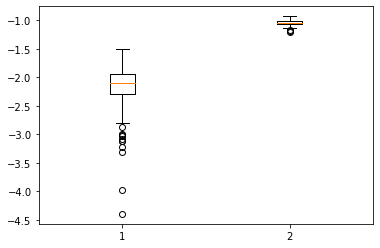

In [14]:
plt.boxplot(fits_random_dna, positions=[1])
plt.boxplot(fits, positions=[2])
plt.show()

In [17]:
fit = np.zeros((len(pop), len(pop)))

for i, geno1 in tqdm(enumerate(pop), total=len(pop)):
    for j, geno2 in enumerate(pop):
        pheno = to_pheno_mix_breed_decode(geno1, geno1, geno2)
        fit[i, j] = task.calc_pheo_fitness(pheno, device=device)['fitness']
        

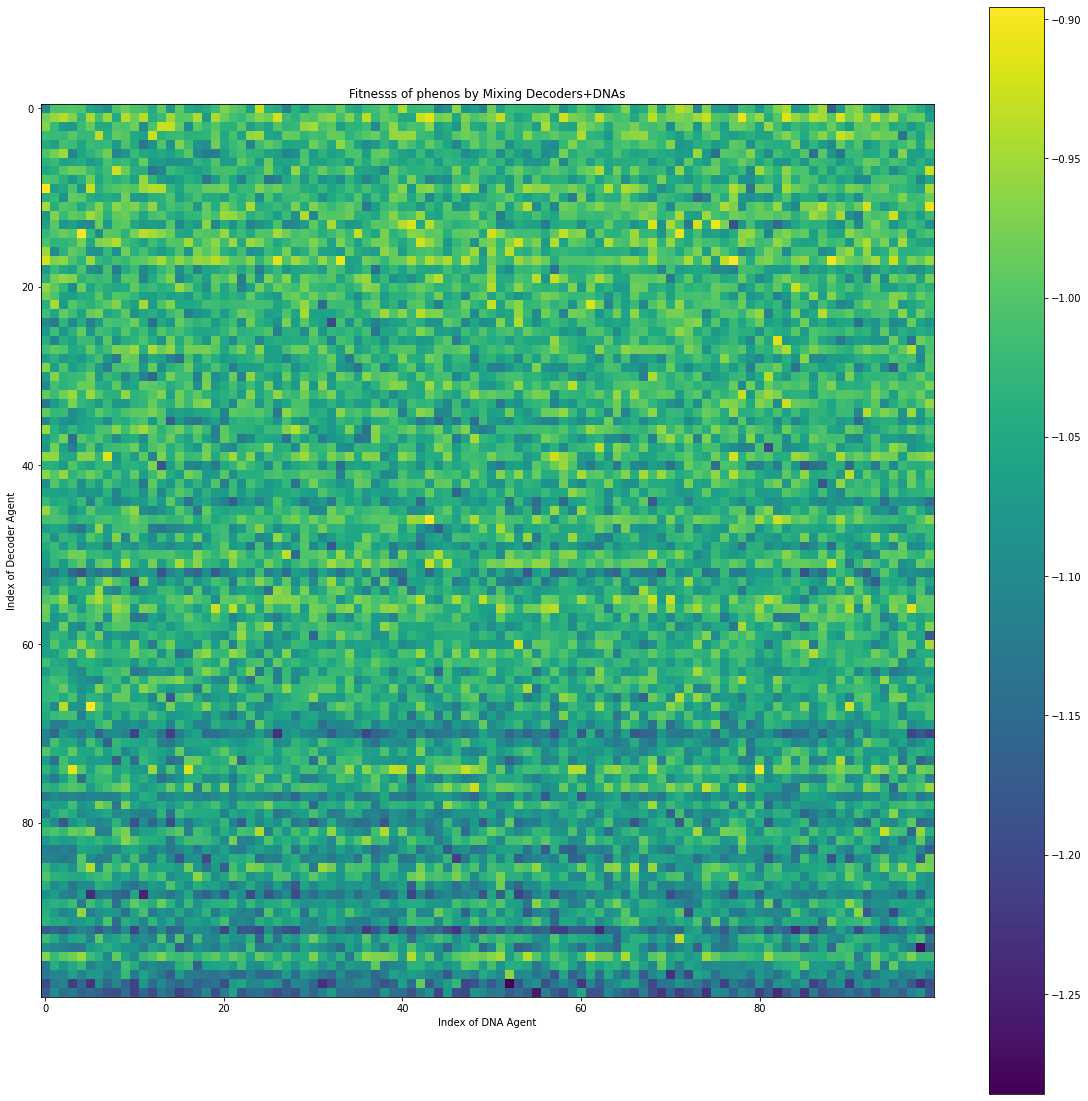

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(fit)
plt.title('Fitnesss of phenos by Mixing Decoders+DNAs');plt.ylabel('Index of Decoder Agent');plt.xlabel('Index of DNA Agent')
plt.colorbar()

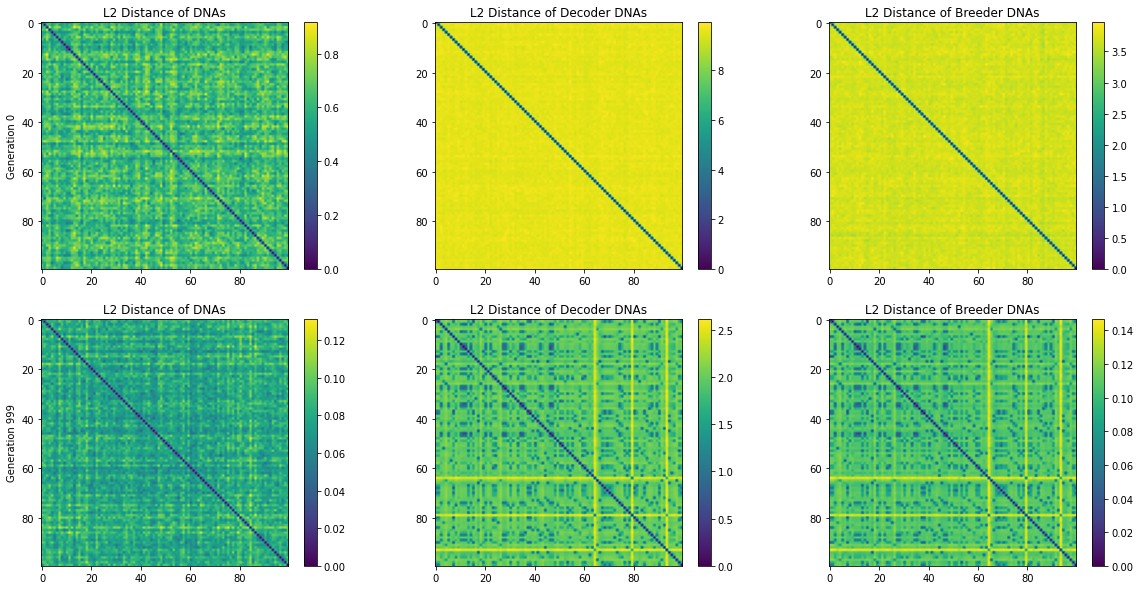

In [30]:
def show_dna_diff(pop):
    a = torch.stack([geno.dna for geno in pop])
    l2_dist = (a[:, None, :] - a[None, :, :]).norm(dim=-1)
    plt.imshow(l2_dist.detach().cpu().numpy());plt.colorbar()
    plt.title('L2 Distance of DNAs')
    
def show_decoder_dna_diff(pop):
    a = torch.stack([geno.decoder_dna for geno in pop])
    l2_dist = (a[:, None, :] - a[None, :, :]).norm(dim=-1)
    plt.imshow(l2_dist.detach().cpu().numpy());plt.colorbar()
    plt.title('L2 Distance of Decoder DNAs')
    
def show_breeder_dna_diff(pop):
    a = torch.stack([geno.breeder_dna for geno in pop])
    l2_dist = (a[:, None, :] - a[None, :, :]).norm(dim=-1)
    plt.imshow(l2_dist.detach().cpu().numpy());plt.colorbar()
    plt.title('L2 Distance of Breeder DNAs')
    
pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{0:05d}'))
plt.figure(figsize=(20, 10))
plt.subplot(231);show_dna_diff(pop);plt.ylabel('Generation 0')
plt.subplot(232);show_decoder_dna_diff(pop)
plt.subplot(233);show_breeder_dna_diff(pop)
pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{999:05d}'))
plt.subplot(234);show_dna_diff(pop);plt.ylabel('Generation 999')
plt.subplot(235);show_decoder_dna_diff(pop)
plt.subplot(236);show_breeder_dna_diff(pop)